# Sequence to Sequence Networks in CNTK

<img src=pix/attn.png>

## Background

Andrej Karpathy has a nice visualization of the five paradigms of neural network architectures:

<img src=http://karpathy.github.io/assets/rnn/diags.jpeg width=750px>

In this tutorial, we are going to be talking about the fourth paradigm: many-to-many, also known as sequence-to-sequence networks. The input is a sequence with a dynamic length, and the output is also a sequence with some dynamic length. It is the logical extension of the many-to-one paradigm in that previously we were predicting some category (which could easily be one of `V` words where `V` is an entire vocabulary) and now we want to predict a whole sequence of those categories.

The applications of sequence-to-sequence networks are nearly limitless. It is a natural fit for machine translation (e.g. English input sequences, French output sequences); automatic text summarization (e.g. full document input sequence, summary output sequence); word to pronunciation models (e.g. character [grapheme] input sequence, pronunciation [phoneme] output sequence); and even parse tree generation (e.g. regular text input, flat parse tree output).

## Basic theory

A sequence-to-sequence model consists of two main pieces: (1) an encoder; and (2) a decoder. Both the encoder and the decoder are recurrent neural network (RNN) layers that can be implemented using a vanilla RNN, an LSTM, or GRU cells (here we will use LSTM). In the basic sequence-to-sequence model, the encoder processes the input sequence into a fixed representation that is fed into the decoder as a context. The decoder then uses some mechanism (discussed below) to decode the processed information into an output sequence. The decoder is a language model that is augmented with some "strong context" by the encoder, and so each symbol that it generates is fed back into the decoder for additional context (like a traditional LM). For an English to German translation task, the most basic setup might look something like this: 

<img src=pix/s2s.png width=700px>

The basic sequence-to-sequence network passes the information from the encoder to the decoder by initializing the decoder RNN with the final hidden state of the encoder as its initial hidden state. The input is then a "sequence start" tag (`<s>` in the diagram above) which primes the decoder to start generating an output sequence. Then, whatever word (or note or image, etc.) it generates at that step is fed in as the input for the next step. The decoder keeps generating outputs until it hits the special "end sequence" tag (`</s>` above).

A more complex and powerful version of the basic sequence-to-sequence network uses an attention model. While the above setup works well, it can start to break down when the input sequences get long. At each step, the hidden state `h` is getting updated with the most recent information, and therefore `h` might be getting "diluted" in information as it processes each token. Further, even with a relatively short sequence, the last token will always get the last say and therefore the thought vector will be somewhat biased/weighted towards that last word. To deal with this problem, we use an "attention" mechanism that allows the decoder to look not only at all of the hidden states from the input, but it also learns which hidden states, for each step in decoding, to put the most weight on. We will discuss an attention implementation at the end of this lab.

## Problem: Grapheme-to-Phoneme Conversion

The [grapheme](https://en.wikipedia.org/wiki/Grapheme) to [phoneme](https://en.wikipedia.org/wiki/Phoneme) problem is a translation task that takes the letters of a word as the input sequence (the graphemes are the smallest units of a writing system) and outputs the corresponding phonemes; that is, the units of sound that make up a language. In other words, the system aims to generate an unambigious representation of how to pronounce a given input word.

### Example

| Letters  | T | A | N | G | E | R |
| --- | --- |
| Phonemes | ~T | ~AE | ~NG | ~ER | null | null |



## Problem: English-to-French Translation

The machine translation problem is well-known and easy to understand: given some English language sentence E (our input sequence), translate it to the equivalent French sentence F (our output sequence). MT researchers have been working on this problem for decades, coming up with ever-more complex systems to eke our the next fraction of a BLEU point. However, sequence-to-sequence networks have in some ways made a lot of their work antiquated (see, e.g. [Neural Machine Translation by Jointly Learning to Align and Translate](http://arxiv.org/abs/1409.0473)).

### Example (from Hansard):
| Language | Sentence | Source |
| --- | --- | --- |
| English | Fueling this growth in royalty revenues is the United States demand, which some day may place our Canadian domestic needs at risk. | hansard.36.2.house.debates.077.e |
| French | Les États-Unis aimeraient bien transformer cette croissance en redevances, ce qui pourrait mettre nos propres besoins en périls. | hansard.36.2.house.debates.077.f |


### Pre-processing and CNTKTextFormat

To input our data, we use the CNTKTextFormat reader. It takes tensors as inputs and allows comments so that we can see what indices represent. Here is an example for the sequence-to-sequence G2P task:

```
0	|S0 3:1 |# <s>	|S1 3:1 |# <s>
0	|S0 4:1 |# A	|S1 32:1 |# ~AH
0	|S0 5:1 |# B	|S1 36:1 |# ~B
0	|S0 4:1 |# A	|S1 31:1 |# ~AE
0	|S0 7:1 |# D	|S1 38:1 |# ~D
0	|S0 12:1 |# I	|S1 47:1 |# ~IY
0	|S0 1:1 |# </s>	|S1 1:1 |# </s>
```

## Step 0: import all of the required functionality...

In [18]:
import numpy as np
import sys
import os
from cntk import Trainer, Axis
from cntk.io import MinibatchSource, CTFDeserializer, StreamDef, StreamDefs, INFINITELY_REPEAT, FULL_DATA_SWEEP
from cntk.learner import momentum_sgd, momentum_schedule
from cntk.ops import input_variable, cross_entropy_with_softmax, classification_error, sequence, slice, past_value, future_value, element_select, alias, hardmax
from cntk.ops.functions import CloneMethod
from cntk.graph import find_nodes_by_name

from nn import LSTMP_component_with_self_stabilization, stabilize, linear_layer, print_training_progress

### Step 0.1: set our model hyperparameters...

In [19]:
cntk_dir = "../../"                                              # data resides in the CNTK folder
data_dir = cntk_dir + "Examples/SequenceToSequence/CMUDict/Data" # under Examples/SequenceToSequence
model_dir = "./Models"
input_vocab_size = 69
label_vocab_size = 69

# model dimensions
input_vocab_dim  = input_vocab_size
label_vocab_dim  = label_vocab_size
hidden_dim = 256
num_layers = 1

## Step 1: setup the input to the network

### Dynamic axes in CNTK

One of the important concepts in understanding CNTK is the idea of two types of axes: static axes, which are the traditional axes of a variable's shape, and dynamic axes, which have dimensions that are unknown until the variable is bound to real data at computation time. They are particularly important in the world of recurrent neural networks. Instead of having to decide a maximum sequence length ahead of time, padding your sequences to that size, and wasting computation, CNTK's dynamic axes allow for variable sequence lengths that are automatically packed in minibatches to be as efficient as possible.

When setting up sequences, there are two dynamic axes that are important to consider. The first is the batch axis, which is the axis along which multiple sequences are batched. The second is the dynamic axis particular to that sequence. The latter is specific to a particular input because of variable sequence lengths in your data. For example, in sequence to sequence networks, we have two sequences: the input sequence, and the ouptput (or 'label') sequence. One of the things that makes this type of network so powerful is that the length of the input sequence and the output sequence do not have to correspond to each other. Therefore, both the input sequence and the output sequence require their own unique dynamic axis.

When defining the input to a network, we set up the required dynamic axes and the shape of the input variables. Below, we define the shape (vocabulary size) of the inputs, create their dynamic axes, and finally create input variables that represent input nodes in our network.

In [20]:
# Source and target inputs to the model
batch_axis = Axis.default_batch_axis()
input_seq_axis = Axis('inputAxis')
label_seq_axis = Axis('labelAxis')

input_dynamic_axes = [batch_axis, input_seq_axis]
raw_input = input_variable(shape=(input_vocab_dim), dynamic_axes=input_dynamic_axes, name='raw_input')

label_dynamic_axes = [batch_axis, label_seq_axis]
raw_labels = input_variable(shape=(label_vocab_dim), dynamic_axes=label_dynamic_axes, name='raw_labels')

### Questions

1. Why do the shapes of the input variables correspond to the size of our dictionaries in sequence to sequence networks?

## Step 2: define the network

As discussed before, the sequence-to-sequence network is, at its most basic, an RNN encoder followed by an RNN decoder, and a dense output layer. We could do this in a few lines with the layers library, but let's go through things in a little more detail without adding too much complexity. The first step is to perform some manipulations on the input data; let's look at the code below and then discuss what we're doing. We will put all of the below in the `create_model()` function from `skeleton.py`...

In [21]:
# Instantiate the sequence to sequence translation model
input_sequence = raw_input

# Drop the sentence start token from the label, for decoder training
label_sequence = slice(raw_labels, label_seq_axis, 
                       1, 0, name='label_sequence') # <s> A B C </s> --> A B C </s>
label_sentence_start = sequence.first(raw_labels)   # <s>

is_first_label = sequence.is_first(label_sequence)  # 1 0 0 0 ...
label_sentence_start_scattered = sequence.scatter(  # <s> 0 0 0 ... (up to the length of label_sequence)
    label_sentence_start, is_first_label)

We have two input variables, `raw_input` and `raw_labels`. Typically, the labels would not have to be part of the network definition because they would only be used in a criterion node when we compare the network's output with the ground truth. However, in sequence-to-sequence networks, the labels themselves form part of the input to the network during training as they are fed as the input into the decoder.

To make use of these input variables, we will pass them through computation nodes. We first set `input_sequence` to `raw_input` as a convenience step. We then perform several modifications to `label_sequence` so that it will work with our network. For now you'll just have to trust that we will make good use of this stuff later.

First, we slice the first element off of `label_sequence` so that it's missing the sentence-start token. This is because the decoder will always first be primed with that token, both during training and evaluation. When the ground truth isn't fed into the decoder, we will still feed in a sentence-start token, so we want to consistently view the input to the decoder as a sequence that starts with an actual value.

Then, we get `label_sequence_start` by getting the `first` element from the sequence `raw_labels`. This will be used to compose a sequence that is the first input to the decoder regardless of whether we're training or decoding. Finally, the last two statements set up an actual sequence, with the correct dynamic axis, to be fed into the decoder. The function `sequence.scatter` takes the contents of `label_sentence_start` (which is `<s>`) and turns it into a sequence with the first element containing the sequence start symbol and the rest of the elements containing 0's.

### Exercise 1: Create the encoder

We will use the LSTM implementation from `examples/common/nn.py`. Its function signature is:

`def LSTMP_component_with_self_stabilization(input, output_dim, cell_dim, recurrence_hookH=past_value, recurrence_hookC=past_value):`

and it returns a tuple `(hidden_state, hidden_cell)`.

1. Create the encoder (set the `output_dim` and `cell_dim` to `hidden_dim` which we defined earlier).
2. Set `num_layers` to something higher than 1 and create a stack of LSTMs to represent the encoder.
3. Get the output of the encoder and put it into the right form to be passed into the decoder [hard]
4. Reverse the order of the `input_sequence` (this has been shown to help especially in machine translation)

### Exercise 2: Create the decoder

In our basic version of the sequence-to-sequence network, the decoder generates an output sequence given the input sequence by setting the initial state of the decoder to the final hidden state of the encoder. The hidden state is represented by a tuple `(encoder_h, encoder_c)` where `h` represents the output hidden state and `c` represents the value of the LSTM cell.

Besides setting the initial state of the decoder, we also need to give the decoder LSTM some input. The first element will always be the special sequence start tag `<s>`. After that, there are two ways that we want to wire up the decoder's input: one during training, and the other during evaluation (i.e. generating sequences on the trained network).

For training, the input to the decoder is the output sequence from the training data, also known as the label(s) for the input sequence. During evaluation, we will instead redirect the output from the network back into the decoder as its history. Let's first set up the input for training...

In [23]:
decoder_input = element_select(is_first_label, label_sentence_start_scattered, past_value(label_sequence))

Above, we use the function `element_select` which will return one of two options given the condition `is_first_label`. Remember that we're working with sequences so when the decoder LSTM is run its input will be unrolled along with the network. The above allows us to to have a dynamic input that will return a specific element given what time step we're currently processing.

Therefore, the `decoder_input` will be `label_sentence_start_scattered` (which is simply `<s>`) when we are at the first time step, and otherwise it will return the `past_value` (i.e. the previous element given what time step we're currently at) of `label_sequence`.

Next, we need to setup our actual decoder. Before, for the encoder, we did the following:

In [24]:
(output_h, output_c) = LSTMP_component_with_self_stabilization(input_sequence, hidden_dim, hidden_dim, 
                                                               recurrence_hookH=past_value, 
                                                               recurrence_hookC=past_value)

To be able to set the first hidden state of the decoder to be equal to the final hidden state of the encoder, we can leverage the parameters `recurrence_hookH` and `recurrent_hookC`. The default `past_value` is a function that returns, for time `t`, the element in the sequence at time `t-1`. See if you can figure out how to set that up.

1. Create the recurrence hooks for the decoder LSTM.
 * Hint: you'll have to create a `lambda operand:` and you will make use of the `is_first_label` mask we used earlier and the `thought_vector_broadcast_h` and `thought_vector_broadcast_c` representations of the output of the encoder.

2. With your recurrence hooks, create the decoder.
 * Hint: again we'll use the `LSTMP_component_with_self_stabilization()` function and again use `hidden_dim` for the `output_dim` and `cell_dim`.
 
3. Create a decoder with multiple layers. Note that you will have to use different recurrence hooks for the lower layers that feed back into the stack of layers.

### Exercise 3: Fully connected layer (network output)

Now we're almost at the end of defining the network. All we need to do is take the output of the decoder, and run it through a linear layer. Ultimately it will be put into a `softmax` to get a probability distribution over the possible output words. However, we will include that as part of our criterion nodes (below).

1. Add the linear layer using the Layers Library to get the final output of the network

## Reader

To efficiently collect our data, randomize it for training, and pass it to the network, we use the CNTKTextFormat reader. We will create a small function that will be called when training (or testing) that defines the names of the streams in our data, and how they are referred to in the raw training data.

In [27]:
def create_reader(path, randomize, size=INFINITELY_REPEAT):
    return MinibatchSource(CTFDeserializer(path, StreamDefs(
        features  = StreamDef(field='S0', shape=input_vocab_dim, is_sparse=True),
        labels    = StreamDef(field='S1', shape=label_vocab_dim, is_sparse=True)
    )), randomize=randomize, epoch_size = size)

We will use the above to create a reader for our training data. Let's create it now:

In [28]:
train_reader = create_reader(os.path.abspath(data_dir) + "\cmudict-0.7b.train-dev-20-21.ctf", True)

## Training

Now that we've created the model, we are ready to train the network and learn its parameters. For sequence-to-sequence networks, the loss we use is cross-entropy. To make things work in the notebook, note that we import an external `create_model()` function. It contains the same logic as what we worked out above, but encapsulates it nicely in a function. We also have to find the `label_sequence` from that model because we've defined a different `label_sequence` above...

In [29]:
from s2s_notebook_helper import create_model, find_arg_by_name

model = create_model()
label_sequence = find_nodes_by_name(model, 'label_sequence')[0]  # only needed in this notebook

# Criterion nodes
ce = cross_entropy_with_softmax(model, label_sequence)
errs = classification_error(model, label_sequence)

print([x.name for x in model.arguments])

['raw_labels', 'raw_input']


Next, we'll setup a bunch of parameters to drive our learning, we'll create the learner, and finally create our trainer:

In [30]:
# training parameters
lr = 0.007
minibatch_size = 72
momentum_time_constant = 1100
m_schedule = momentum_schedule(momentum_time_constant)
clipping_threshold_per_sample = 2.3
gradient_clipping_with_truncation = True

# create learner (we use momentum_sgd but could use sgd or adam or...)
learner = momentum_sgd(model.parameters, lr, m_schedule, 
                       clipping_threshold_per_sample, gradient_clipping_with_truncation)
trainer = Trainer(model, ce, errs, learner)

And now we bind the features and labels from our `train_reader` to the inputs that we setup in our network definition:

In [31]:
train_bind = {
        find_arg_by_name('raw_input' , model) : train_reader.streams.features,
        find_arg_by_name('raw_labels', model) : train_reader.streams.labels
    }

Finally, we define our training loop and start training the network!

In [32]:
training_progress_output_freq = 100
for i in range(1000):
    # get next minibatch of training data
    mb_train = train_reader.next_minibatch(minibatch_size, input_map=train_bind)
    trainer.train_minibatch(mb_train)

    # collect epoch-wide stats
    print_training_progress(trainer, i, training_progress_output_freq)

Minibatch: 0, Train Loss: 4.231082313939145, Train Evaluation Criterion: 0.9824561403508771
Minibatch: 100, Train Loss: 2.952935236150568, Train Evaluation Criterion: 0.8181818181818182
Minibatch: 200, Train Loss: 2.6438919067382813, Train Evaluation Criterion: 0.74
Minibatch: 300, Train Loss: 2.1364201564414826, Train Evaluation Criterion: 0.7058823529411765
Minibatch: 400, Train Loss: 1.7914764404296875, Train Evaluation Criterion: 0.5454545454545454
Minibatch: 500, Train Loss: 1.6666787719726563, Train Evaluation Criterion: 0.44
Minibatch: 600, Train Loss: 1.238189697265625, Train Evaluation Criterion: 0.2909090909090909
Minibatch: 700, Train Loss: 1.8038042302717243, Train Evaluation Criterion: 0.47368421052631576
Minibatch: 800, Train Loss: 1.3085376091723173, Train Evaluation Criterion: 0.41509433962264153
Minibatch: 900, Train Loss: 1.0807312610102635, Train Evaluation Criterion: 0.3137254901960784


## Model evaluation: greedy decoding

Once we have a trained model, we of course then want to make use of it to generate output sequences! In this case, we will use greedy decoding. What this means is that we will run an input sequence through our trained network, and when we generate the output sequence, we will do so one element at a time by taking the `hardmax()` of the output of our network. This is obviously not optimal in general. Given the context, some word may always be the most probable at the first step, but another first word may be preferred given what is output later on. Decoding the optimal sequence is intractable in general. But we can do better doing a beam search where we keep around some small number of hypotheses at each step. However, greedy decoding can work surprisingly well for sequence-to-sequence networks because so much of the context is kept around in the RNN.

To do greedy decoding, we need to make a small modification to our original network. Previously, our `decoder_input` looked like this:

`decoder_input = element_select(is_first_label, label_sentence_start_scattered, past_value(label_sequence))`

Now, we will create a "hook" that will be able to represent `label_sequences` during training, and the network's output `net_output` during evaluation. So, we will modify the above to:

In [33]:
decoder_history_hook = alias(label_sequence, name='decoder_history_hook') # copy label_sequence
decoder_input = element_select(is_first_label, label_sentence_start_scattered, past_value(decoder_history_hook))

That's it. Now we train our network as before. When we do evaluation, however, we'll need to supply a new value for the `decoder_history_hook`. We can set it up like this:

In [34]:
from Sequence2Sequence import create_model, create_reader, get_vocab, train
model = create_model() # this is the new model with included history hook

# get some references to the new model
label_sequence = find_nodes_by_name(model, 'label_sequence')[0]    
decoder_history_hook = find_nodes_by_name(model, 'decoder_history_hook')[0]  

# and now replace the output of decoder_history_hook with the hardmax output of the network
def clone_and_hook():
    # network output for decoder history
    net_output = hardmax(model)

    # make a clone of the graph where the ground truth is replaced by the network output
    return model.clone(CloneMethod.share, {decoder_history_hook.output : net_output.output})

# get a new model that uses the past network output as input to the decoder
new_model = clone_and_hook()

The `new_model` now contains a version of the original network that shares parameters with it but that has a different input to the decoder. Namely, instead of feeding the ground truth labels into the decoder, it will feed in the history that the network has generated!

Finally, let's see what it looks like if we train, and keep evaluating the network's output every `100` iterations by running a word's graphemes ('A B A D I') through our network. This way we can visualize the progress learning the best model...

In [35]:
# hook up data
train_reader = create_reader(data_dir + "/cmudict-0.7b.train-dev-20-21.ctf", True)
valid_reader = create_reader("tiny.ctf", False)
vocab, i2w = get_vocab(data_dir + "/cmudict-0.7b.mapping")

# create model
model = create_model()
    
# train
# UNCOMMENT DURING TALK
#train(train_reader, valid_reader, vocab, i2w, model, max_epochs=1)

## Attention

An important extension to sequence-to-sequence models, especially when dealing with long sequences, is to use an attention mechanism. The idea behind attention is to allow the decoder, first, to look at any of the hidden state outputs from the encoder (instead of using only the final hidden state), and, second, to learn how much attention to pay to each of those hidden states given the context. This allows the outputted word at each time step `t` to depend not only on the final hidden state and the word that came before it, but instead on a weighted combination of *all* of the input hidden states!

There are a number of different attention implementations, but here we describe the one from Vinyals, et al. "Grammar as a Foreign Language" (https://arxiv.org/abs/1412.7449). Here, an attention vector at output time $t$ over the input words $(1, ..., T_A)$ is defined as:

$$u_i^t = v^T tanh( W_1 h_i + W_2 d_t)$$
$$a_i^t = softmax(u_i^t)$$
$$d'_t = \sum_{i=1}^{T_A}{a_i^t h_i}$$

where $h_i$ is the $i$th encoder hidden state; $d_t$ is the $t$th decoder hidden state (so the current hidden state for the decoder); and $v$, $W_1$, and $W_2$ are parameters to learn. We then calculate $a_i^t$ which is an attention mask over the hidden states. It amounts to a probability distribution over those hidden states to determine how much attention should be paid to each hidden state output in the encoder.

Finally, we pass $d'_t$ as an auxiliary input to our LSTM so that in computing the normal step function in the decoder LSTM we will concatenate $d_t$ and $d'_t$. This is the new state that we use to make predictions.

### CNTK implementation

We then need to make a number of modifications to our original network. First, we no longer want the initial state of the decoder to be the final hidden state of the encoder. The decoder only uses the attention mechanism as the context it needs to generate the output sequences. Therefore, the `recurrence_hook` is simply `past_value` as in the default case. We also need to pass in an `augment_input_hook` which amounts to a function that will calculate the $d'_t$ from above. The decoder is then setup as follows:

In [36]:
from nn import create_attention_augment_hook

attention_dim = 256
attention_span = 20
augment_input_hook = create_attention_augment_hook(attention_dim, attention_span, label_sequence, encoder_output_h)

(decoder_output_h, encoder_output_c) = LSTMP_component_with_self_stabilization(
            decoder_output_h.output, hidden_dim, hidden_dim, recurrence_hook_h, recurrence_hook_c, 
            augment_input_hook, hidden_dim)

The function `creation_attention_augment_hook` is currently defined only locally in the `nn.py` file for this tutorial. The full details are beyond the scope of this tutorial, but at a high level it first sets up a `past_value_window` that looks back over the length of the `attention_span`. The values in this window are used in the above equation as the $h_i$ to compute the `attention_weights`. To be sure that the attention mechanism is likely learning what we want it to, it can be useful to log these weights and plot them. That's what we'll do next...

### Quick aside on logging / debugging in CNTK

As the beta progresses CNTK2 will acquire some nice APIs to easily look into all of the data that is flowing into and out of all nodes in your network. For now, we will use a more "brute force" approach by logging every single tensor that runs through the network. To do so, we will use a very high level of trace logging turned on like this:

In [ ]:
import cntk as C
C.cntk_py.set_computation_network_trace_level(1000000)

This will give a huge amount of output. We keep it small by turning it on and off selectively only every `N` iterations and only when we run an evaluation. I did this while training the above network with attention enabled on the G2P task. We end up with a huge file with contents that look something like this:

```
Dump --> __v2libuid__Parameter5811__v2libname__ = LearnableParameter() :  -> [69]
  -0.0057577454
   0.0502184778
  -0.0057698647
  -0.0058023389
  -0.0057756277
  -0.0058013676
  -0.0058887773
  -0.0057583693
  -0.0057594362
```

I pulled out the contents of the `attention_weights` node for 6 different points during training when I ran our validation sequence ('ABADI') through the network. It's in this notebook directory as "attweightdata.txt". We can then plot it in various ways...

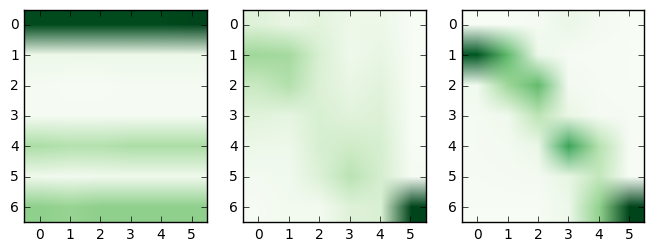

In [37]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

X = np.zeros(shape=(7,6), dtype=np.float)
times=[]

i=0
for line in open('attweightdata.txt').readlines():
    data = [x for x in reversed(line.split())]
    if len(data) > 1:
        X[i,:] = data
        i += 1
    else:
        times.append(X)
        X = np.zeros(shape=(7,6), dtype=np.float)
        i=0

first = times[0]
middle = times[2]
last = times[len(times)-1]

f, ax = plt.subplots(1, 3, figsize=(8,4))
ax[0].imshow(first, cmap='Greens')
ax[1].imshow(middle, cmap='Greens')
ax[2].imshow(last, cmap='Greens')

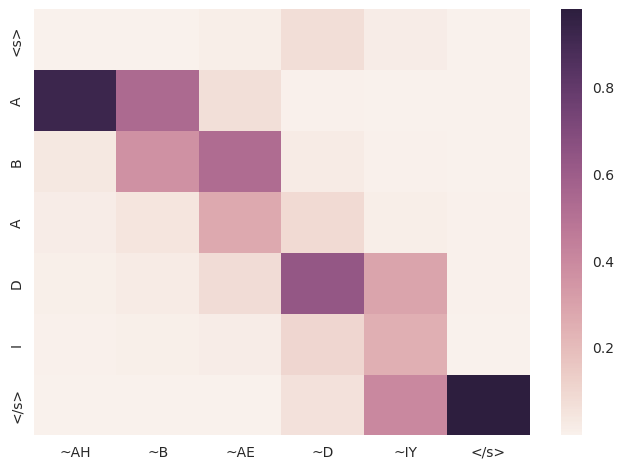

In [38]:
import seaborn as sns
import pandas as pd

columns = ['~AH', '~B', '~AE', '~D', '~IY', '</s>']
index = ['<s>', 'A', 'B', 'A', 'D', 'I', '</s>']
dfirst = pd.DataFrame(data=first, columns=columns, index=index)
dlast = pd.DataFrame(data=last, columns=columns, index=index)

#sns.heatmap(dfirst)
sns.heatmap(dlast)
#sns.heatmap(dlast, annot=True)

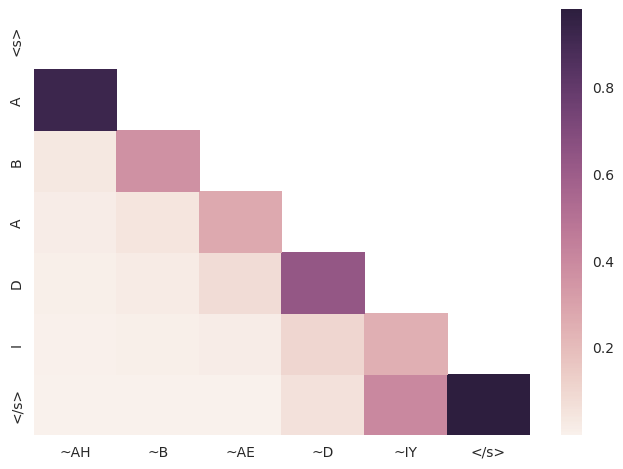

In [39]:
mask = np.zeros_like(dlast)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(dlast, mask=mask)

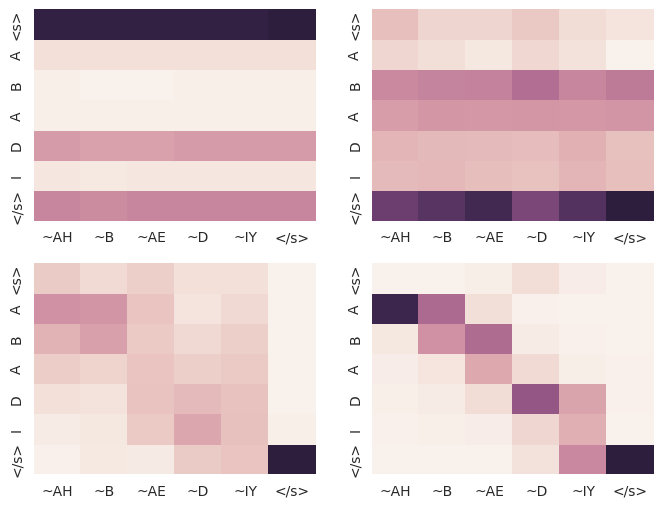

In [40]:
f, ax = plt.subplots(2, 2, figsize=(8,6))
sns.heatmap(pd.DataFrame(data=times[0], columns=columns, index=index), cbar=False, ax=ax[0, 0])
sns.heatmap(pd.DataFrame(data=times[1], columns=columns, index=index), cbar=False, ax=ax[0, 1])
sns.heatmap(pd.DataFrame(data=times[2], columns=columns, index=index), cbar=False, ax=ax[1, 0])
sns.heatmap(pd.DataFrame(data=times[4], columns=columns, index=index), cbar=False, ax=ax[1, 1])

## Solutions

### Exercise 1


In [22]:
# 1.
# Create the encoder (set the output_dim and cell_dim to hidden_dim which we defined earlier).

(encoder_output_h, encoder_output_c) = LSTMP_component_with_self_stabilization(input_sequence, hidden_dim, hidden_dim)

# 2.
# Set num_layers to something higher than 1 and create a stack of LSTMs to represent the encoder.
num_layers = 2
output_h = stabilize(input_sequence)
for i in range(0, num_layers):
    (output_h, output_c) = LSTMP_component_with_self_stabilization(output_h.output, hidden_dim, hidden_dim)

# 3.
# Get the output of the encoder and put it into the right form to be passed into the decoder [hard]
thought_vector_h = sequence.first(output_h)
thought_vector_c = sequence.first(output_c)

thought_vector_broadcast_h = sequence.broadcast_as(thought_vector_h, label_sequence)
thought_vector_broadcast_c = sequence.broadcast_as(thought_vector_c, label_sequence)

# 4.
# Reverse the order of the input_sequence (this has been shown to help especially in machine translation)
(encoder_output_h, encoder_output_c) = LSTMP_component_with_self_stabilization(input_sequence, 
                                                                               hidden_dim, hidden_dim, 
                                                                               future_value, future_value)

### Exercise 2

In [25]:
# 1. 
# Create the recurrence hooks for the decoder LSTM.

recurrence_hook_h = lambda operand: element_select(is_first_label, thought_vector_broadcast_h, past_value(operand))
recurrence_hook_c = lambda operand: element_select(is_first_label, thought_vector_broadcast_c, past_value(operand))

# 2.
# With your recurrence hooks, create the decoder.

(decoder_output_h, decoder_output_c) = LSTMP_component_with_self_stabilization(
                                        decoder_input, hidden_dim, hidden_dim, 
                                        recurrence_hook_h, recurrence_hook_c)

# 3.
# Create a decoder with multiple layers. 
# Note that you will have to use different recurrence hooks for the lower layers

num_layers = 3
decoder_output_h = stabilize(decoder_input)
for i in range(0, num_layers):
    if (i > 0):
        recurrence_hook_h = past_value
        recurrence_hook_c = past_value
    else:
        recurrence_hook_h = lambda operand: element_select(
            is_first_label, thought_vector_broadcast_h, past_value(operand))
        recurrence_hook_c = lambda operand: element_select(
            is_first_label, thought_vector_broadcast_c, past_value(operand))

    (decoder_output_h, decoder_output_c) = LSTMP_component_with_self_stabilization(
        decoder_output_h.output, hidden_dim, hidden_dim, recurrence_hook_h, recurrence_hook_c)

### Exercise 3

In [26]:
# 1.
# Add the linear layer

z = linear_layer(stabilize(decoder_output_h), label_vocab_dim)